In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

We are going to do time series analysis and forecasting for furniture sales.

In [2]:
df = pd.read_excel("Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

In [3]:
furniture.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
7,7475,CA-2011-167199,2013-01-06,2013-01-10,Standard Class,ME-17320,Maria Etezadi,Home Office,United States,Henderson,...,42420,South,FUR-CH-10004063,Furniture,Chairs,Global Deluxe High-Back Manager's Chair,2573.820,9,0.0,746.4078
14,7661,CA-2011-105417,2013-01-07,2013-01-12,Standard Class,VS-21820,Vivek Sundaresam,Consumer,United States,Huntsville,...,77340,Central,FUR-FU-10004864,Furniture,Furnishings,"Howard Miller 14-1/2"" Diameter Chrome Round Wa...",76.728,3,0.6,-53.7096
19,867,CA-2011-149020,2013-01-10,2013-01-15,Standard Class,AJ-10780,Anthony Jacobs,Corporate,United States,Springfield,...,22153,South,FUR-FU-10000965,Furniture,Furnishings,"Howard Miller 11-1/2"" Diameter Ridgewood Wall ...",51.940,1,0.0,21.2954
20,717,CA-2011-130092,2013-01-11,2013-01-14,First Class,SV-20365,Seth Vernon,Consumer,United States,Dover,...,19901,East,FUR-FU-10000010,Furniture,Furnishings,"DAX Value U-Channel Document Frames, Easel Back",9.940,2,0.0,3.0814
26,2979,CA-2011-109232,2013-01-13,2013-01-16,Second Class,ND-18370,Natalie DeCherney,Consumer,United States,Mount Pleasant,...,29464,South,FUR-CH-10000422,Furniture,Chairs,Global Highback Leather Tilter in Burgundy,545.940,6,0.0,87.3504


We have a good 4-year furniture sales data. 

In [4]:
furniture['Order Date'].min()

Timestamp('2013-01-06 00:00:00')

In [5]:
furniture['Order Date'].max()

Timestamp('2016-12-30 00:00:00')

## Data preprocessing

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [6]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')

In [7]:
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [8]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [9]:
furniture.head()

,Order Date,Sales
0,2013-01-06,2573.820
1,2013-01-07,76.728
2,2013-01-10,51.940
3,2013-01-11,9.940
4,2013-01-13,879.939


## Indexing with time series data

In [10]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2013-01-06', '2013-01-07', '2013-01-10', '2013-01-11',
               '2013-01-13', '2013-01-14', '2013-01-16', '2013-01-19',
               '2013-01-20', '2013-01-21',
               ...
               '2016-12-18', '2016-12-19', '2016-12-21', '2016-12-22',
               '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-28',
               '2016-12-29', '2016-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [11]:
y = furniture['Sales'].resample('MS').mean()

Have a quick peek 2017 sales data.

In [12]:
y['2016':]

Order Date
2016-01-01     397.602133
2016-02-01     528.179800
2016-03-01     544.672240
2016-04-01     453.297905
2016-05-01     678.302328
2016-06-01     826.460291
2016-07-01     562.524857
2016-08-01     857.881889
2016-09-01    1209.508583
2016-10-01     875.362728
2016-11-01    1277.817759
2016-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

## Visualizing furniture sales time series data

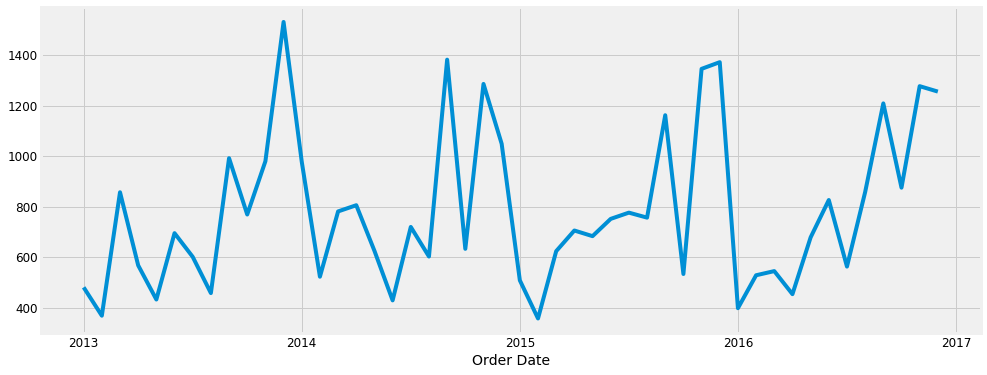

In [13]:
y.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always a strong upward trend within any single year with a couple of low months in the mid of the year.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

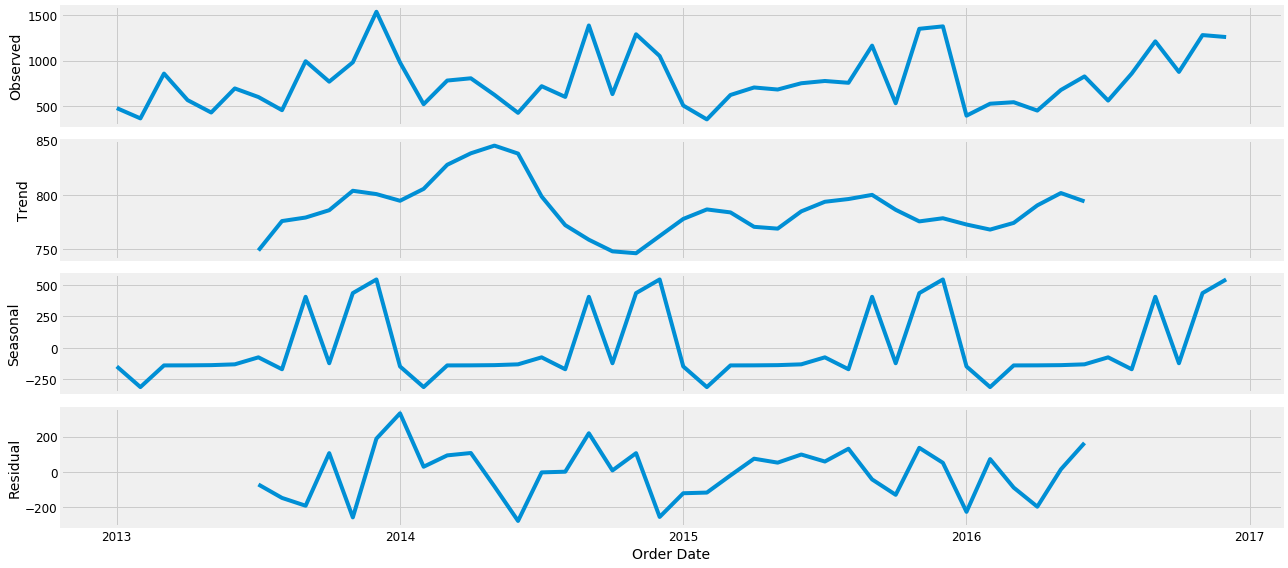

In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

## Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

Parameter Selection for the ARIMA Time Series Model

In [15]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [16]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.1028329076864


C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1496.034338268343
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.3880661554051
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:496.941688492852


C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1257.3489459304465
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:319.4769282249068
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:721.805470252606


C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.2292493113578
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:498.5015256250556
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:266321.56841550424
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:321.47680101884566
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:679.8426756921882
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1353.5909706368557
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:486.39264018642643
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.71214734967083


C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1239.0368360679674
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:321.3936311404286
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:650.8057227355999
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:2514.089824751119
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.5749841482586
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.0900255270141
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:2552.446891696283
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:308.5900472352634
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:694.0509358217613


C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1475.396793359791
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:479.1280776489843
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:480.59877058921893


C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1335.9905284519907
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:305.53265395152056
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:666.7655840930229


C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2666.8358981327738
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:468.21536610148837
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:481.6722694643284
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:3318.306509123873
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:305.01987675819396
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:672.8145653210245


C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1282.971899605264
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:479.9529645628843
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:476.3039885690283
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:2066.2458043333586
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:303.43385289169373
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:650.3325731986489
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:8708.851714096709
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:460.1675918469134
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:469.44124881268533
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:89556.223307915
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:297.4152113711294


In [17]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0054      0.318      0.017      0.987      -0.618       0.629
ma.L1         -1.0000      0.403     -2.480      0.013      -1.790      -0.210
ar.S.L12      -0.0219      0.039     -0.557      0.577      -0.099       0.055
sigma2      2.898e+04   1.39e-05   2.08e+09      0.000     2.9e+04     2.9e+04


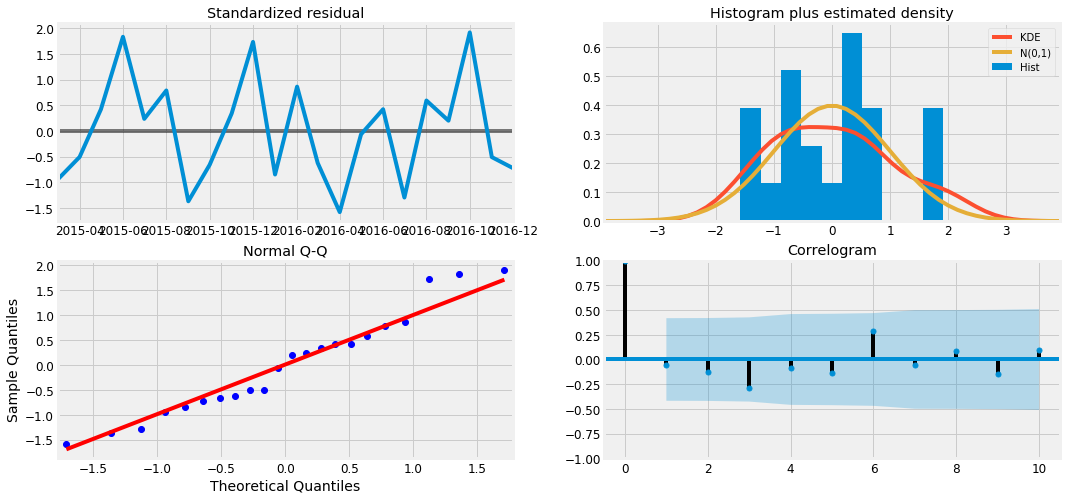

In [18]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Validating forecasts

To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017-07-01 to the end of the data.

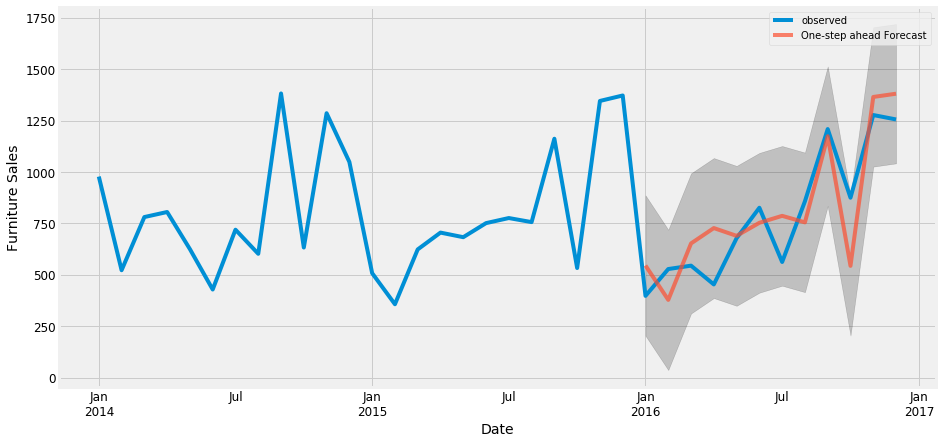

In [19]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year.

In [20]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is nan


In [21]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is nan


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.

## Producing and visualizing forecasts

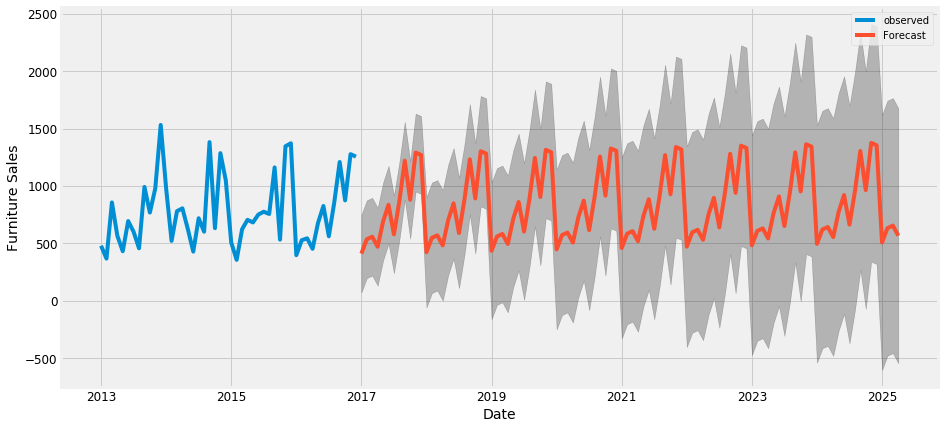

In [22]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()

Our model clearly captured furniture sales seasonality. As we forecast further out into the future, it is natural for us to become less confident in our values. This is reflected by the confidence intervals generated by our model, which grow larger as we move further out into the future.

The above time series analysis for furniture makes me curious about other categories, and how do they compare with each other onver time. Therefore, we are going to compare time series of furniture and office supplier.

## Time Series comparison furniture sales and Office Supplies

### Data Preprocessing

In [23]:
furniture = df.loc[df['Category'] == 'Furniture']
office = df.loc[df['Category'] == 'Office Supplies']

According to our data, there were way more number of sales from Office Supplies than from Furniture over the years.

In [24]:
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [25]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

Have a quick peek, perfect!

In [26]:
furniture.head()

,Order Date,Sales
0,2013-01-06,2573.820
1,2013-01-07,76.728
2,2013-01-10,51.940
3,2013-01-11,9.940
4,2013-01-13,879.939


In [27]:
office.head()

,Order Date,Sales
0,2013-01-03,16.448
1,2013-01-04,288.060
2,2013-01-05,19.536
3,2013-01-06,685.340
4,2013-01-07,10.430


### Data exploration

We are going to compare two categories' sales in the same time period. This means combine two data frames into one and plot these two categories' time series into one plot.

In [28]:
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

store = furniture.merge(office, how='inner', on='Order Date')
store.rename(columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'}, inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2013-01-01,480.194231,285.357647
1,2013-02-01,367.931600,63.042588
2,2013-03-01,857.291529,391.176318
3,2013-04-01,567.488357,464.794750
4,2013-05-01,432.049187,324.346545


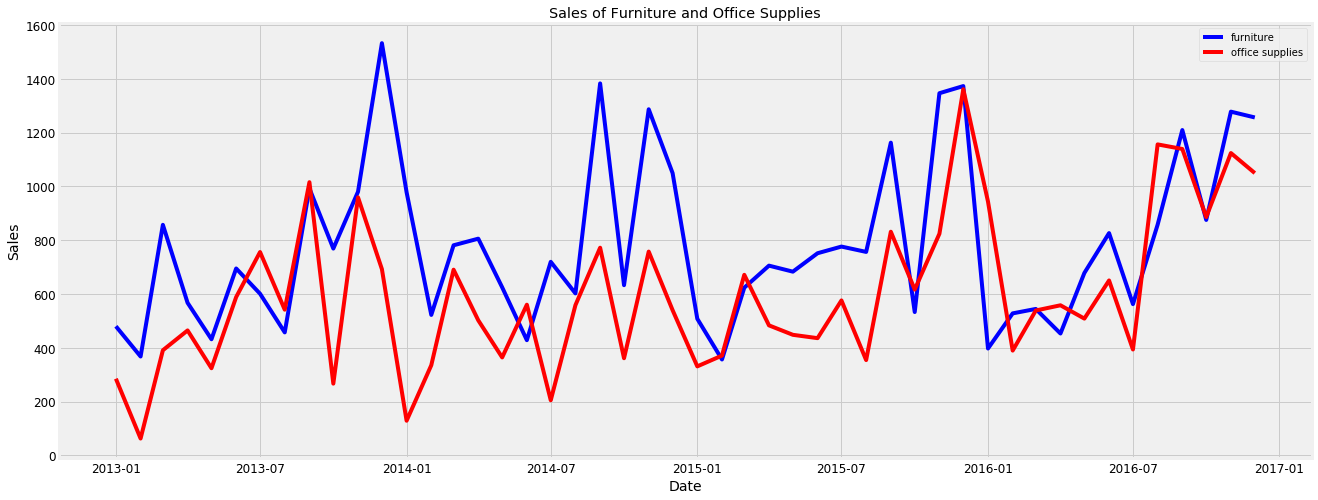

In [29]:
plt.figure(figsize=(20, 8))
plt.plot(store['Order Date'], store['furniture_sales'], 'b-', label = 'furniture')
plt.plot(store['Order Date'], store['office_sales'], 'r-', label = 'office supplies')
plt.xlabel('Date'); plt.ylabel('Sales'); plt.title('Sales of Furniture and Office Supplies')
plt.legend();

We observe that sales of furniture and office supplies shared a similar seasonal pattern. Early of the year is the off season for both of the two categories. It seems summer time is quiet for office supplies too. in addition, average daily sales for furniture are higher than those of office supplies in most of the months. It is understandable, as the value of furniture should be much higher than those of office supplies. Occationaly, office supplies passed furnitue on average daily sales. Let's find out when was the first time office supplies' sales surpassed those of furniture's. 

In [30]:
first_date = store.ix[np.min(list(np.where(store['office_sales'] > store['furniture_sales'])[0])), 'Order Date']

print("Office supplies first time produced higher sales than furniture is {}.".format(first_date.date()))

Office supplies first time produced higher sales than furniture is 2013-07-01.


It was July 2014.

### Time Series Modeling with Prophet

Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.

In [43]:
import fbprophet as pr

In [44]:
pr.Prophet?

In [40]:
from fbprophet import Prophet

In [42]:
Prophet?

In [41]:
dir(Prophet)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'add_country_holidays',
 'add_group_component',
 'add_regressor',
 'add_seasonality',
 'construct_holiday_dataframe',
 'fit',
 'fourier_series',
 'initialize_scales',
 'linear_growth_init',
 'logistic_growth_init',
 'make_all_seasonality_features',
 'make_future_dataframe',
 'make_holiday_features',
 'make_seasonality_features',
 'parse_seasonality_args',
 'piecewise_linear',
 'piecewise_logistic',
 'plot',
 'plot_components',
 'predict',
 'predict_seasonal_components',
 'predict_trend',
 'predict_uncertainty',
 'predictive_samples',
 'regressor_column_matrix',
 'sample_model',
 'sample_posterior_predictive',
 'sample_pre

In [46]:
office

,ds,y
0,2013-01-01,285.357647
1,2013-02-01,63.042588
2,2013-03-01,391.176318
3,2013-04-01,464.794750
4,2013-05-01,324.346545
5,2013-06-01,588.774409
6,2013-07-01,756.060400
7,2013-08-01,541.879143
8,2013-09-01,1015.677704
9,2013-10-01,267.078815


In [47]:
Prophet?

In [48]:
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

<Figure size 1296x432 with 0 Axes>

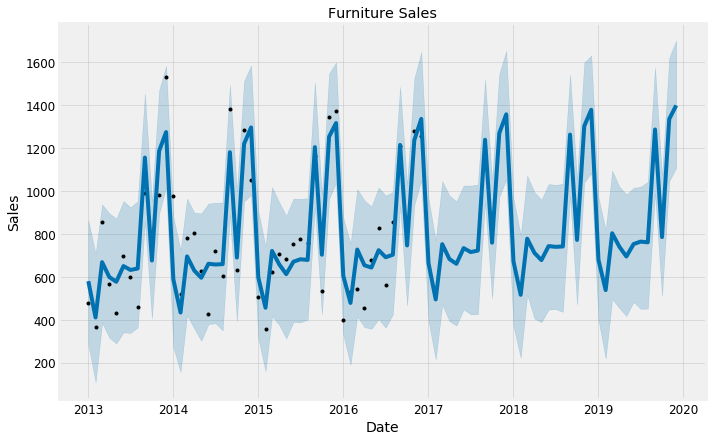

In [33]:
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

<Figure size 1296x432 with 0 Axes>

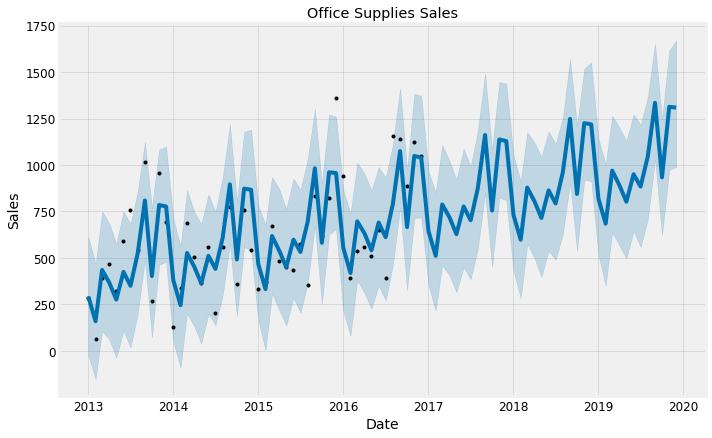

In [34]:
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

### Compare Forecasts

We already have the forecasts for three years for these two categories into the future. We will now join them together to compare their future forecasts.

In [35]:
furniture_names = ['furniture_%s' % column for column in furniture_forecast.columns]
office_names = ['office_%s' % column for column in office_forecast.columns]

merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()

merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

forecast = pd.merge(merge_furniture_forecast, merge_office_forecast, how = 'inner', left_on = 'furniture_ds', right_on = 'office_ds')

forecast = forecast.rename(columns={'furniture_ds': 'Date'}).drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2013-01-01,742.421886,284.517685,863.353353,742.421886,742.421886,-162.435529,-162.435529,-162.435529,-162.435529,...,-132.917470,-132.917470,-132.917470,-132.917470,-132.917470,-132.917470,0.0,0.0,0.0,291.851302
1,2013-02-01,744.289741,109.009456,708.386995,744.289741,744.289741,-333.474828,-333.474828,-333.474828,-333.474828,...,-273.154149,-273.154149,-273.154149,-273.154149,-273.154149,-273.154149,0.0,0.0,0.0,159.089071
2,2013-03-01,745.976837,386.058716,937.901536,745.976837,745.976837,-77.324495,-77.324495,-77.324495,-77.324495,...,-3.381899,-3.381899,-3.381899,-3.381899,-3.381899,-3.381899,0.0,0.0,0.0,435.612434
3,2013-04-01,747.844693,316.197401,895.858473,747.844693,747.844693,-148.795433,-148.795433,-148.795433,-148.795433,...,-79.678210,-79.678210,-79.678210,-79.678210,-79.678210,-79.678210,0.0,0.0,0.0,366.790570
4,2013-05-01,749.652295,289.829129,871.382154,749.652295,749.652295,-172.451810,-172.451810,-172.451810,-172.451810,...,-178.029168,-178.029168,-178.029168,-178.029168,-178.029168,-178.029168,0.0,0.0,0.0,275.672949


### Visualizing the trend and the forecast

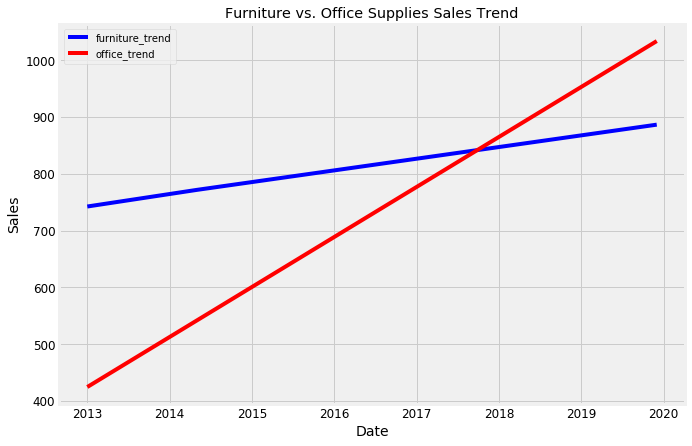

In [36]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-')
plt.plot(forecast['Date'], forecast['office_trend'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Sales Trend');

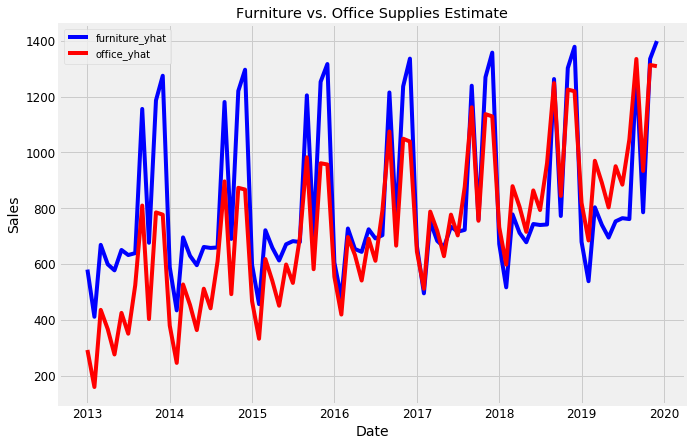

In [37]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-')
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-')
plt.legend(); plt.xlabel('Date'); plt.ylabel('Sales')
plt.title('Furniture vs. Office Supplies Estimate');

### Trends and Patterns

Now, we can use the Prophet Models to inspect different trends of these two categories in the data.

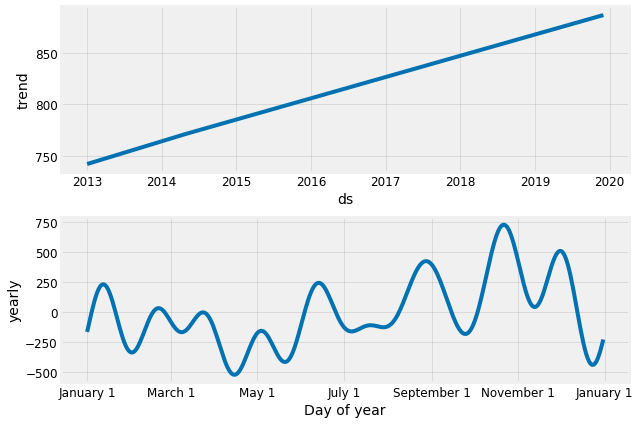

In [38]:
furniture_model.plot_components(furniture_forecast);

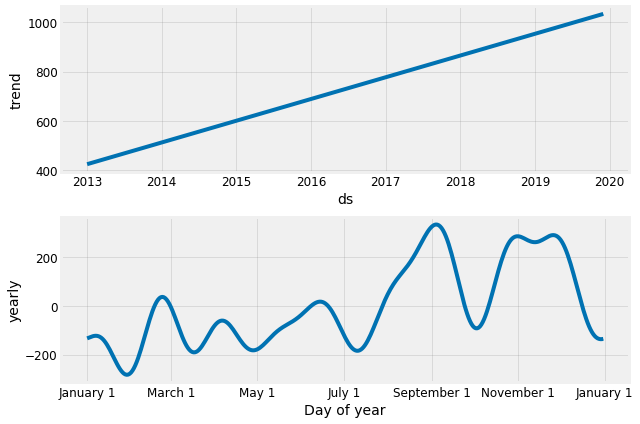

In [39]:
office_model.plot_components(office_forecast);

Good to see that the sales for both furniture and office supplies have been linearly increasing over time although office supplies' growth seems slightly stronger.

The worst month for furniture is April, the worst month for office supplies is February. The best month for furniture is December, and the best month for office supplies is November.

There are many time-series analysis we can explore from now on, such as forecast with uncertainty bounds, change point and anomaly detection, forecast time-series with external data source. We have only scratched the surface here. Stay tuned for future works on time-series analysis.